In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# read datasets, data taken from public csv from the EPA and NCCA
# original df is https://www.epa.gov/sites/default/files/2021-04/ncca_2015_water_chemistry_great_lakes-data.csv
# df for secchi disks (SD) is found here https://www.epa.gov/system/files/other-files/2023-02/Final%20NCCA%20GL%20Special%20Study%20%282014-2018%29%20data%20and%20metadata.zip 
# df for dissolved oxygen (DO) is in the same site
df = pd.read_csv("ncca_2015_water_chemistry_great_lakes-data.csv")
dfSD = pd.read_csv("ncca_2014-2018_secchi_great_lakes_special_study_data.csv")
dfDO = pd.read_csv("ncca_2014-2018_hydrographic_profile_great_lakes_special_study_data.csv")

# data is split into 4 batches to allow for 3 to train the model and then 1 to test the accuracy

# non-TSI but important variables

# pH readings
pHList = [[], [], [], []]
pHAvg = [0] * 4
df = df.dropna(subset=['RESULT'])
for index, row in df.loc[df['ANALYTE'] == "PH"].iterrows():
    day, month, yr = row['DATE_COL'].split("-")
    # data starts from June and goes to Sep
    if month == 'Jun':
        pHList[0].append(row['RESULT'])
    elif month == 'Jul':
        pHList[1].append(row['RESULT'])
    elif month == 'Aug':
        pHList[2].append(row['RESULT'])
    else:
        pHList[3].append(row['RESULT'])
for t, i in enumerate(pHList):
    pHAvg[t] = sum(i)/(len(i))

# dissolved oxygen (DO) readings
DOList = [[], [], [], []]
DOAvg = [0] * 4
dfDO = dfDO.dropna(subset=['DO'])
for index, row in dfDO.loc[dfDO['STUDY'] == "Lake_Erie_Study"].iterrows():
    day, month, yr = row['DATE_COL'].split("-")
    # data starts from June and goes to Sep
    if month == 'Jun':
        DOList[0].append(row['DO'])
    elif month == 'Jul':
        DOList[1].append(row['DO'])
    elif month == 'Aug':
        DOList[2].append(row['DO'])
    else:
        DOList[3].append(row['DO'])
for t, i in enumerate(DOList):
    DOAvg[t] = sum(i)/(len(i))

# TSI variables

# Chlorophyll A (CHLA) readings 
CHLAList = [[], [], [], []]
CHLA_Avg = [0] * 4
for index, row in df.loc[df['ANALYTE'] == "CHLA"].iterrows():
    day, month, yr = row['DATE_COL'].split("-")
    # data starts from June and goes to Sep
    if month == 'Jun':
        CHLAList[0].append(row['RESULT'])
    elif month == 'Jul':
        CHLAList[1].append(row['RESULT'])
    elif month == 'Aug':
        CHLAList[2].append(row['RESULT'])
    else:
        CHLAList[3].append(row['RESULT'])
for t, i in enumerate(CHLAList):
    CHLA_Avg[t] = sum(i)/(len(i))

# Secchi Disk (SD) readings
# Secchi Disk Depth is the depth when the disk disappears and measures turbidity
SDList = [[], [], [], []]
SDAvg = [0] * 4
dfSD = dfSD.dropna(subset=['DISAPPEARS'])
for index, row in dfSD.loc[dfSD['STUDY'] == "Lake_Erie_Study"].iterrows():
    day, month, yr = row['DATE_COL'].split("-")
    # data starts from June and goes to Sep
    if month == 'Jun':
        SDList[0].append(row['DISAPPEARS'])
    elif month == 'Jul':
        SDList[1].append(row['DISAPPEARS'])
    elif month == 'Aug':
        SDList[2].append(row['DISAPPEARS'])
    else:
        SDList[3].append(row['DISAPPEARS'])
for t, i in enumerate(SDList):
    SDAvg[t] = sum(i)/(len(i))

# Total Phosphorus (TP) readings 
TPList = [[], [], [], []]
TPAvg = [0] * 4
for index, row in df.loc[df['ANALYTE'] == "PTL"].iterrows():
    day, month, yr = row['DATE_COL'].split("-")
    # data starts from June and goes to Sep
    if month == 'Jun':
        TPList[0].append(row['RESULT'])
    elif month == 'Jul':
        TPList[1].append(row['RESULT'])
    elif month == 'Aug':
        TPList[2].append(row['RESULT'])
    else:
        TPList[3].append(row['RESULT'])
for t, i in enumerate(TPList):
    TPAvg[t] = sum(i)/(len(i))

DOpoints = DOAvg
pHpoints = pHAvg

In [29]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init


# model
class neuralnet(nn.Module):
    def __init__(self, insize, hiddensize, outsize):
        super(neuralnet, self).__init__()
        self.hidden = nn.Linear(insize, hiddensize)
        self.output = nn.Linear(hiddensize, outsize)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.hidden(x))
        x = self.relu(self.output(x))
        return x
    def initialize_weights(x):
        if isinstance(x, nn.Linear):
            init.xavier_uniform_(x.weight)
    

# avgs
def avg(x):
    for t, i in enumerate(x):
        x[t] = sum(i)/len(i)


# train data
xtrain = [[CHLA_Avg[0], TPAvg[0], SDAvg[0]], [CHLA_Avg[1], TPAvg[1], SDAvg[1]], [CHLA_Avg[2], TPAvg[2], SDAvg[2]]] #3x3 matrix, 3 samples 3 inputs (CHLA, TP, SD)
ytrain = [[pHAvg[0], DOAvg[0]], [pHAvg[1], DOAvg[1]], [pHAvg[2], DOAvg[2]]]#3x2 matrix, 3 samples 2 outputs (pH, DO)
xtrain = torch.tensor(xtrain)
ytrain = torch.tensor(ytrain)

# sizes
insize = 3
hiddensize = 128
outsize = 2

model = neuralnet(insize, hiddensize, outsize)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training
for i in range(len(xtrain)):
    epochs = 100
    for e in range(epochs):
        model.train()
        outputs = model(xtrain[i])
        loss = criterion(outputs, ytrain[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if e%10 == 0:
            print(f'Epoch [{e+1}/{epochs}], Loss: {loss.item():.4f}')

# predictions
testSet = [[CHLA_Avg[3], TPAvg[3], SDAvg[3]]]
testSet = torch.tensor(testSet)

model.eval()
with torch.no_grad():
    prediction = model(testSet)
    print("Prediction:", prediction)

# error calculation
ans = [pHAvg[3], DOAvg[3]]
ans = torch.tensor(ans)
MSE = np.square(np.subtract(ans, prediction)).mean()
print(ans, prediction)
print(MSE)

Epoch [1/100], Loss: 71.9439
Epoch [11/100], Loss: 5.3383
Epoch [21/100], Loss: 4.4331
Epoch [31/100], Loss: 0.2244
Epoch [41/100], Loss: 0.5665
Epoch [51/100], Loss: 0.0291
Epoch [61/100], Loss: 0.0637
Epoch [71/100], Loss: 0.0151
Epoch [81/100], Loss: 0.0020
Epoch [91/100], Loss: 0.0039
Epoch [1/100], Loss: 0.2569
Epoch [11/100], Loss: 0.0076
Epoch [21/100], Loss: 0.0251
Epoch [31/100], Loss: 0.0057
Epoch [41/100], Loss: 0.0008
Epoch [51/100], Loss: 0.0015
Epoch [61/100], Loss: 0.0002
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0001
Epoch [91/100], Loss: 0.0000
Epoch [1/100], Loss: 0.1221
Epoch [11/100], Loss: 0.0131
Epoch [21/100], Loss: 0.0018
Epoch [31/100], Loss: 0.0042
Epoch [41/100], Loss: 0.0015
Epoch [51/100], Loss: 0.0001
Epoch [61/100], Loss: 0.0000
Epoch [71/100], Loss: 0.0001
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000
Prediction: tensor([[7.7177, 8.3636]])
tensor([8.0552, 8.8082]) tensor([[7.7177, 8.3636]])
tensor(0.1558)


[51.372014741468085, 45.42603848369146, 49.004510694114884, 37.30760262903177, 37.30760262903177] [7.994999999999998, 8.070642201834865, 8.08461538461538, 8.055211267605632, tensor(7.6698)] [9.043486238532116, 8.23132608695652, 8.905276752767525, 8.808150851581509, tensor(0.)]


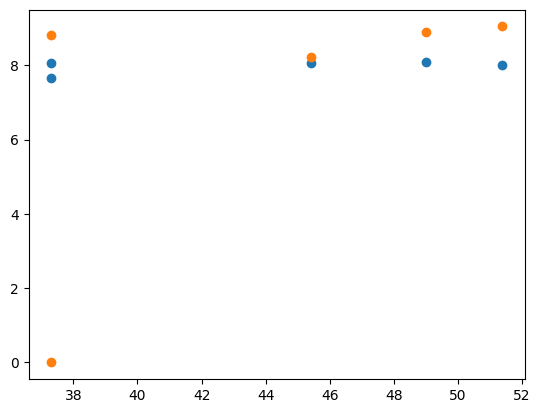

In [3]:
# graphs

# this just graphs the values, not very useful but u can see the relation of actual TSI to the DO & pH
TSIpoints = []
for i in range(len(CHLA_Avg)):
    TSIsd = 60-14.41*np.log(SDAvg[i])
    TSIchl = 9.81*np.log(CHLA_Avg[i])+30.6
    # unit conv
    TSItp = 14.42*np.log(TPAvg[i]*1000)+4.15
    TSIpoints.append((TSIsd + TSIchl + TSItp)/3)
TSIpoints.append(TSIpoints[-1])
pHtemp = pHAvg
DOtemp = DOAvg
pHtemp.append(prediction[0][0])
DOtemp.append(prediction[0][1])
#pHtemp.pop()
#DOtemp.pop()
print(TSIpoints, pHtemp, DOtemp)

plt.scatter(TSIpoints, pHtemp)
plt.scatter(TSIpoints, DOtemp)